<a href="https://colab.research.google.com/github/naderghanbari/mcgill-capstone/blob/master/mcgill_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import libraries

### Install geopandas

In [205]:
!pip install geopandas

### Import libraries

In [206]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

# Data collection

### Montreal firefighter interventions

In [207]:
# Collect Montreal firefighter interventions from 2015 to date
%%bash
mkdir -p interventions
curl http://donnees.ville.montreal.qc.ca/dataset/701683f0-a838-4fe0-b4d6-a4964d9ea7f0/resource/9e67d2f3-9104-4af4-aac4-022df621a749/download/donneesouvertes-interventions-sim.csv --silent --output interventions/interventions.csv
echo Number of lines: `wc -l interventions/*`

Number of lines: 641828 interventions/interventions.csv


### Montreal fire stations

In [208]:
# Collect Montreal fire stations dataset
%%bash
mkdir -p stations
curl http://donnees.ville.montreal.qc.ca/dataset/c69e78c6-e454-4bd9-9778-e4b0eaf8105b/resource/f6542ad1-31f5-458e-b33d-1a028fab3e98/download/casernes.csv --silent --output stations/stations.csv
echo Number of lines: `wc -l stations/*`

Number of lines: 69 stations/stations.csv


### Montreal fire divisions

In [209]:
# Collect Montreal fire station divisions dataset
%%bash
mkdir -p divisions
curl https://storage.googleapis.com/capstone-data-lake/divisions/divisions.csv --silent --output divisions/divisions.csv
echo Number of lines: `wc -l divisions/*`

Number of lines: 68 divisions/divisions.csv


### Montreal crimes

In [210]:
# Collect Montreal crime data from 2015 to date
%%bash
mkdir -p crimes
curl http://donnees.ville.montreal.qc.ca/dataset/5829b5b0-ea6f-476f-be94-bc2b8797769a/resource/c6f482bf-bf0f-4960-8b2f-9982c211addd/download/interventionscitoyendo.csv --silent --output crimes/crimes.csv
echo Number of lines: `wc -l crimes/*`

Number of lines: 171443 crimes/crimes.csv


### Montreal hourly weather

In [211]:
# Collect Montreal hourly weather data from 2015 to 2019
%%bash
FROM=2015
TO=2019
STATION=30165
mkdir -p weather
for year in $(seq $FROM $TO); do
  for month in {01..12}; do
    curl https://climate.weather.gc.ca/climate_data/bulk_data_e.html\?format\=csv\&stationID\=$STATION\&Year\=$year\&Month\=$month\&Day\=1\&timeframe\=1\&submit\=Download+Data --silent --output weather/$year-$month.csv &
  done;
done

In [212]:
# Count check
assert(len(os.listdir("weather")) == 60)

# Data cleanup and preprocessing

### Stations

In [248]:
# Read stations to a Pandas dataframe and keep only relevant columns
stations = pd.read_csv(
  "stations/stations.csv", 
  dtype={"CASERNE": "int"},
)
stations.rename(
  columns={
    "CASERNE": "station",
    "LATITUDE": "latitude",
    "LONGITUDE": "longitude",
  }, 
  inplace=True,
)
stations = stations[["station","latitude","longitude"]]
stations = stations.set_index("station")
stations = gpd.GeoDataFrame(
  stations, 
  geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
)
stations.head()

,latitude,longitude,geometry
station,,,
3,45.493454,-73.560172,POINT (-73.56017 45.49345)
15,45.484419,-73.560917,POINT (-73.56092 45.48442)
23,45.477925,-73.585251,POINT (-73.58525 45.47793)
33,45.457841,-73.595450,POINT (-73.59545 45.45784)
9,45.563748,-73.610169,POINT (-73.61017 45.56375)


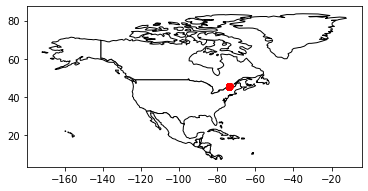

In [214]:
# Visual check for latitude and longitude
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
north_america = world[world.continent == "North America"]
ax = north_america.plot(color="white", edgecolor="black")
stations.plot(ax=ax,color='red');

### Divisions

In [249]:
# Read divisions to a Pandas dataframe
divisions = pd.read_csv(
  "divisions/divisions.csv", 
  dtype={
    "station": "int", 
    "division": "string",
  },
)
divisions = divisions.set_index("station")
divisions.head()

,division
station,
51,1
52,1
53,1
54,1
55,1


In [243]:
# Assert number of divisions matches expectation
assert(divisions["division"].unique() == 6)

### Merge Stations and Divisions
In tis step we merge the stations dataframe with divisions. This will automatically filter out the only decommissioned station, so there is no 
need to manually remove it from the dataset.

In [250]:
# Merge stations with divisions
stations_with_division = stations.join(divisions, how="inner").reset_index()
stations_with_division.head()

,station,latitude,longitude,geometry,division
0,3,45.493454,-73.560172,POINT (-73.56017 45.49345),2
1,15,45.484419,-73.560917,POINT (-73.56092 45.48442),2
2,23,45.477925,-73.585251,POINT (-73.58525 45.47793),2
3,33,45.457841,-73.595450,POINT (-73.59545 45.45784),2
4,9,45.563748,-73.610169,POINT (-73.61017 45.56375),4


In [253]:
# Assert that number of active stations mathces expectation
assert(stations_with_division.index.size == 67)

### Interventions
Now we load the interventions dataset, which is our main dataset.

In [254]:
# Load interventions into a Pandas dataframe
interventions = pd.read_csv(  
  "interventions/interventions.csv", 
  usecols=["CREATION_DATE_TIME","CASERNE","DIVISION","NOMBRE_UNITES"], 
  dtype={
    "CASERNE": "int",
    "DIVISION": "string",
    "NOMBRE_UNITES": pd.Int64Dtype(),
  },
  parse_dates=["CREATION_DATE_TIME"],
)

# Fill empty or NaN NOMBRE_UNITES with 0
interventions["NOMBRE_UNITES"] = interventions["NOMBRE_UNITES"].fillna(0).astype(int)

# Standardize column names
interventions.rename(
  columns={
    "CREATION_DATE_TIME": "incident_time",
    "CASERNE": "station", 
    "DIVISION": "target_division",
    "NOMBRE_UNITES": "units_deployed",
  }, 
  inplace=True,
)

interventions.head()

,incident_time,station,target_division,units_deployed
0,2015-08-10 17:53:07,29,7,1
1,2015-08-12 03:26:56,38,9,1
2,2015-08-12 23:38:30,40,7,1
3,2015-08-13 20:45:33,30,7,1
4,2015-08-01 04:53:57,72,3,1


### Merge Interventions and Divisions
Now we merge interventions with divisions so for each incident we know
exactly which division responded to the call.

In [256]:
# Merge interventions with divisions
interventions_with_division = interventions.join(
  divisions, 
  on="station", 
  how="inner",
)
interventions_with_division.head()

,incident_time,station,target_division,units_deployed,division
0,2015-08-10 17:53:07,29,7,1,5
30,2015-09-07 12:23:40,29,7,7,5
80,2015-08-25 19:03:42,29,7,2,5
157,2015-01-27 11:00:51,29,7,37,5
219,2015-02-23 23:48:24,29,7,1,5


### Crimes

In [257]:
# Read crimes dataset into a Pandas dataframe
crimes = pd.read_csv("crimes/crimes.csv", encoding="ISO-8859-1")
crimes.rename(columns={"DATE":"date", "LATITUDE":"latitude", "LONGITUDE":"longitude"}, inplace=True)
crimes = crimes[["date","latitude","longitude"]]
crimes.head()

,date,latitude,longitude
0,2018-09-13,45.567780,-73.626778
1,2018-04-30,45.567780,-73.626778
2,2018-09-01,45.519122,-73.685928
3,2017-07-21,1.000000,1.000000
4,2017-07-29,1.000000,1.000000


In [258]:
# Cleanup by removing bad latitude and longitudes
crimes_good_latitudes = crimes["latitude"].between(45.3583897,45.7735297)
crimes_good_longitudes = crimes["longitude"].between(-74.1045037,-73.365220)
crimes = crimes[crimes_good_latitudes & crimes_good_longitudes]

# Add a geometry column
crimes = gpd.GeoDataFrame(
  crimes, 
  geometry=gpd.points_from_xy(crimes.longitude, crimes.latitude),
)
crimes.head()

,date,latitude,longitude,geometry
0,2018-09-13,45.567780,-73.626778,POINT (-73.62678 45.56778)
1,2018-04-30,45.567780,-73.626778,POINT (-73.62678 45.56778)
2,2018-09-01,45.519122,-73.685928,POINT (-73.68593 45.51912)
6,2017-07-30,45.516776,-73.591457,POINT (-73.59146 45.51678)
8,2017-08-01,45.602873,-73.635117,POINT (-73.63512 45.60287)


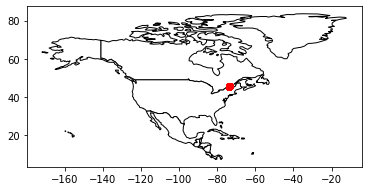

In [222]:
# Visual check for latitude and longitude
ax = north_america.plot(color="white",edgecolor="black")
crimes.plot(ax=ax,color='red');

# Aggregation

### Interventions per Date/Division

In [259]:
# Exctract the date as a new column
interventions_with_division["date"] = interventions_with_division["incident_time"].dt.date
# Add a fixed column of 1 for grouping and counting purposes
interventions_with_division["incidents"] = 1

interventions_with_division.head()

,incident_time,station,target_division,units_deployed,division,date,incidents
0,2015-08-10 17:53:07,29,7,1,5,2015-08-10,1
30,2015-09-07 12:23:40,29,7,7,5,2015-09-07,1
80,2015-08-25 19:03:42,29,7,2,5,2015-08-25,1
157,2015-01-27 11:00:51,29,7,37,5,2015-01-27,1
219,2015-02-23 23:48:24,29,7,1,5,2015-02-23,1


In [260]:
# Function to group by a dataframe by date and division columns
def group_by_date_division(df, agg_cols):
  group_calls = ["date", "division"]
  all = group_calls + agg_cols
  return df[all].groupby(group_calls).sum().reset_index()

# Aggregate number of incidents and units deployed per date/division
# SELECT incident_date, division, SUM(units_deployed), COUNT(incidents) FROM interventions GROUP BY incident_date, division

incidents_date_division = group_by_date_division(
  interventions_with_division, 
  ["incidents","units_deployed"],
)
incidents_date_division.head()

,date,division,incidents,units_deployed
0,2015-01-01,1,34,59
1,2015-01-01,2,81,140
2,2015-01-01,3,70,118
3,2015-01-01,4,70,92
4,2015-01-01,5,84,137


In [261]:
# Assert that the number of incidents is still the same as before aggregation
assert(incidents_date_division.incidents.sum() == interventions_with_division.incidents.sum())

# Assert that the number of unitis is still the same as before aggregation
assert(incidents_date_division.units_deployed.sum() == interventions_with_division.units_deployed.sum())